# Step 5.1: Supplementary vizualziation

__Step goals__: Make regplots for population vs entry by station cluster.

__Step overview__:
1. Load the data;
2. Make regplots;
3. Construct station network;
4. Plot it;
5. Visualize distance vs station type. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import ticker
import networkx as nx
import shapely
from haversine import haversine
from scipy import stats
import matplotlib.colors as colors
plt.style.use('science')

## 1. Load the data

In [2]:
font = {'size' : 12}
matplotlib.rc('font', **font)

In [3]:
# Load the data
entry_voronoi = gpd.read_file('../data/processed/counts/entry_voronoi.json')
entry_station_cluster = gpd.read_file('../data/interim/counts/entry_station_cluster.json')

# Merge the data for plotting
df = pd.merge(entry_station_cluster, entry_voronoi[['station', 'adult_population']], left_on='station_name', right_on='station')

In [4]:
# Define label names and corresponding colors
label_names = ["Inner residential", "Polycentre", "CBD", "Mixed commuting", "Outer residential", "Potential feeder"]
label_color_map = {"Outer residential": "#FF2C00", "CBD": "#00B945", "Polycentre": "#845B97", 
                   "Inner residential": "#FF9500", "Potential feeder": "#0C5DA5", "Mixed commuting": "#474747"}

## 2. Make regplots

Initial shape 50
After removed 50
Initial shape 41
After removed 41
Initial shape 61
After removed 61
Initial shape 10
After removed 10
Initial shape 16
After removed 16
Initial shape 63
After removed 60


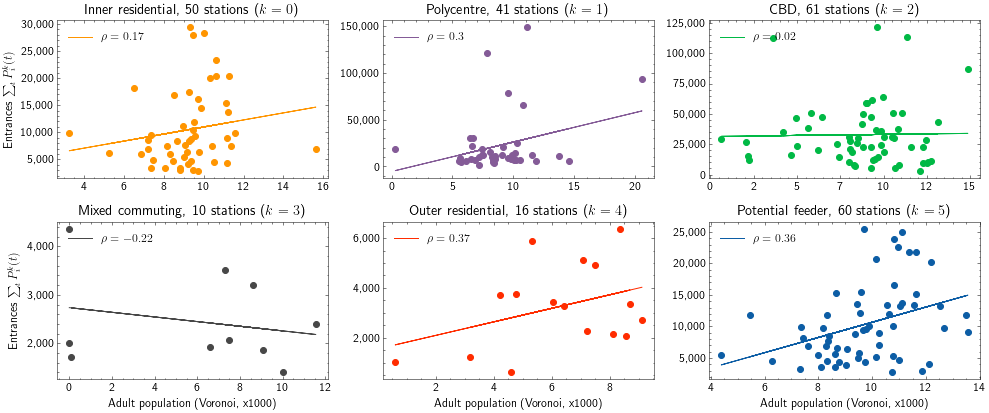

In [8]:
l = [_ for _ in range(0,6)]
k = 0
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,6))

corr_data = {}

for row in range(0, 2):
    for col in range(0, 3):
        data = df[df['label'] == l[k]]
        
        pop = pd.DataFrame(data['total'])
        q1 = pop.quantile(0.1)
        q3 = pop.quantile(0.9)
        iqr = q3 - q1
        pop = pop[~((pop < (q1 - 1.5 * iqr)) | (pop > (q3 + 1.5 * iqr))).any(axis=1)]
        print(f'Initial shape {data.shape[0]}')
        print(f'After removed {pop.shape[0]}')
        
        x = data.loc[pop.index, 'adult_population'].div(1000)
        y = data.loc[pop.index, 'total']
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        line = slope*x + intercept
        corr_data[label_names[k]] = [x, y]
        ax[row, col].plot(x, line, color=label_color_map[label_names[k]], label=fr'$\rho={round(r_value, 2)}$')
        ax[row, col].scatter(x, y, color=label_color_map[label_names[k]])
        ax[row, col].set_title(f'{label_names[k]}, {pop.shape[0]} stations ($k={k}$)')
        ax[row, col].get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda y, p: format(int(y), ","))
        )
        ax[row, col].get_xaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )
        if (row == 0 and col == 0) or (row == 1 and col == 0):
            ax[row, col].set_ylabel(f'Entrances $\sum_t P_i^k(t)$')
        else:
            ax[row, col].set_ylabel("")
            
        if row == 1:
            ax[row, col].set_xlabel("Adult population (Voronoi, x1000)")
        else:
            ax[row, col].set_xlabel("")
        ax[row, col].legend(loc='upper left')
        k += 1
fig.tight_layout()
plt.savefig('../figures/fig4.png', dpi=300)

In [26]:
corr_coef = {}
for key, values in corr_data.items():
    corr = pd.DataFrame(values).T.corr().iloc[1, 0]
    corr_coef[key] = corr

In [27]:
pd.DataFrame(corr_coef, index=['Pearson correlation coefficient']).to_csv('../data/interim/corr_coef.csv')

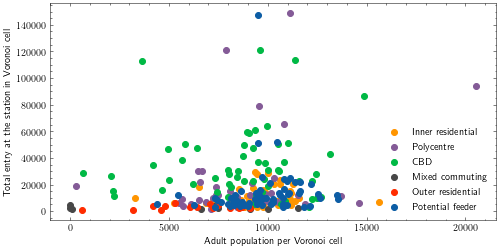

In [28]:
plt.figure(figsize=(8,4))
l = [_ for _ in range(0,6)]
k = 0
for row in range(0, 2):
    for col in range(0, 3):
        ax = plt.scatter(x='adult_population', y='total', data=df[df['label'] == l[k]], 
                         c=label_color_map[label_names[k]], label=f'{label_names[k]}')
        k += 1
clusters = ['0', '1', '2', '3', '4', '5']
plt.ylabel("Total entry at the station in Voronoi cell")
plt.xlabel("Adult population per Voronoi cell")
plt.legend();
plt.savefig('../figures/pop.eps')

## 3. Construct station network

In [19]:
nodes = pd.read_csv("../data/processed/geometry/metro_stations/nodes.csv")
entry_station_cluster = gpd.read_file('../data/interim/counts/entry_station_cluster.json').to_crs(epsg=32630)
nodes["geometry"] = [shapely.geometry.Point(p) for p in list(zip(nodes.longitude.values, nodes.latitude.values))]
nodes = gpd.GeoDataFrame(nodes)
nodes.crs = {"init": "epsg:4326"}
nodes.head()

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\spacetimegeo\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,id,latitude,longitude,name,display_name,zone,total_lines,rail,geometry
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,2.0,0.0,POINT (-0.28010 51.50280)
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2.0,0.0,POINT (-0.07550 51.51430)
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2.0,0.0,POINT (-0.07260 51.51540)
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1.0,0.0,POINT (-0.01300 51.51070)
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1.0,0.0,POINT (-0.29970 51.54070)


In [16]:
nodes = nodes.rename({"name": "station_name"}, axis=1)
nodes = nodes.to_crs(epsg=32630)

In [17]:
nodes_cleaned = pd.merge(nodes, entry_station_cluster[["station_name", "label_name"]], on="station_name")

In [18]:
# node_map = nodes['geometry'].to_dict()
# node_map = nodes.set_index('id')['geometry'].to_dict()
node_map = nodes_cleaned.set_index("id")["geometry"].to_dict()

In [19]:
lines = pd.read_csv("../data/processed/geometry/metro_stations/lines.csv")
lines["point1"] = lines.station1.map(node_map)
lines["point2"] = lines.station2.map(node_map)
lines = gpd.GeoDataFrame(lines)
lines.crs = nodes.crs

In [20]:
# lines['geometry'] = ([shapely.geometry.LineString([p1,p2]) for (p1,p2) in lines[['point1','point2']].values])
lines = lines.dropna()
lines["geometry"] = [shapely.geometry.LineString([p1, p2]) for (p1, p2) in lines[["point1", "point2"]].values]

In [21]:
# sample_nodes = nodes.to_crs(epsg=4326)
sample_nodes = nodes_cleaned # .to_crs(epsg=32630)

X = [node.x for node in sample_nodes["geometry"]]
Y = [node.y for node in sample_nodes["geometry"]]
ID = sample_nodes["id"]
# len(coord_pairs)

In [22]:
G = nx.Graph()
node_pos = {}
for x, y, i in zip(X, Y, ID):
    node_pos[i] = (x, y)
    G.add_node(i, pos={i: (x, y)})

In [23]:
sample_edges = lines # .to_crs(epsg=4326)
edgelist = []
for index, row in sample_edges.iterrows():
    G.add_edge(u_of_edge=row["station1"], v_of_edge=row["station2"])
    edgelist.append((row["station1"], row["station2"]))

In [24]:
border = gpd.read_file("../data/raw/geometry/london_simplified/london.shp")
population = gpd.read_file('../data/processed/population/wards.json')

In [25]:
labels = nodes_cleaned['label_name']

## 4. Plot stations colored by cluster in a network 

In [26]:
# Specify colors for plotting
label_color_map = {"Outer residential": "#FF2C00",
                   "CBD": "#00B945",
                   "Polycenter": "#845B97",
                   "Inner residential": "#FF9500",
                   "Potential feeder": "#0C5DA5",
                   "Mixed commuting": "#474747"}
label_color = [label_color_map[i] for i in labels]

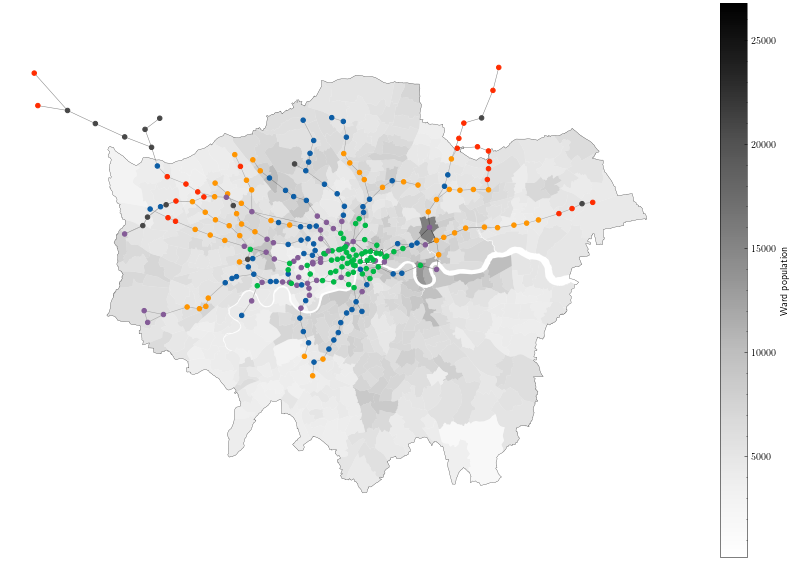

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx_edges(G, pos=node_pos, edgelist=edgelist, edge_color="gray", width=.5)
nx.draw_networkx_nodes(G, pos=node_pos, node_size=20, node_color=label_color) # , edge_color="k")


norm = colors.Normalize(vmin=population['adult_population'].min(), vmax=population['adult_population'].max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='Greys')

population.to_crs(epsg=32630).plot(ax=ax, column='adult_population', cmap='Greys', alpha=0.5, legend=False);

border.to_crs(epsg=32630).plot(ax=ax, color='None', edgecolor='k', linewidth=.25)

ax_cbar = fig.colorbar(cbar, ax=ax)
ax_cbar.set_label('Ward population')

plt.axis('off');
plt.savefig('../figures/fig3c.png', dpi=600)
fig.tight_layout()

## 5. Get distances from city center to each of the stations

In [9]:
# Define the center point
center = (-0.1278, 51.5074)

# Calculate and assign the distance 
distances = []
for lon, lat in zip(entry_station_cluster['lon'].tolist(), entry_station_cluster['lat'].tolist()):
    station = (lon, lat)
    d = haversine(center, station)
    distances.append(round(d, 1))
entry_station_cluster['distance'] = distances

# Save result
entry_station_cluster.to_file('../data/interim/counts/entry_station_cluster_distance.json', driver='GeoJSON')

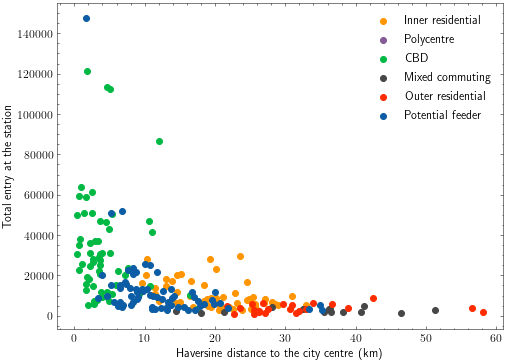

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
n_labels = entry_station_cluster['label'].max()
# label_names = entry_station_cluster['label_name'].unique()
for k in range(0, n_labels + 1):
    data = entry_station_cluster[entry_station_cluster['label_name'] == label_names[k]]
    label_name = label_names[k]
    x = data['distance']
    y = data['total']
    color = label_color_map[label_name]
    plt.scatter(x, y, color=color, label=label_name)
plt.xlabel('Haversine distance to the city centre (km)')
plt.ylabel('Total entry at the station')
plt.legend();
plt.savefig('../figures/distance_entry_cluster.eps')

In [30]:
entry_station_cluster['label_name'].replace({'Polycenter' : 'Polycentre'}, inplace=True)

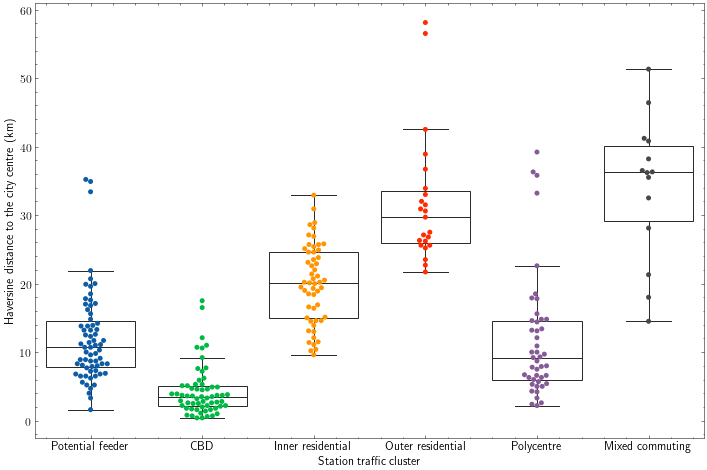

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
sns.swarmplot(x='label_name', y="distance", hue="label_name", data=entry_station_cluster, ax=ax)
sns.boxplot(x='label_name', y="distance", hue="label_name", data=entry_station_cluster, dodge=False, 
            boxprops={'facecolor':'None'},
            showfliers=False,ax=ax)
plt.xlabel('Station traffic cluster')
plt.ylabel('Haversine distance to the city centre (km)');
ax.get_legend().remove()
plt.savefig('../figures/sfig6.png', dpi=300)